In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dir = '/content/drive/MyDrive/boats'

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
import tensorflow_datasets as tfds

dataset_name = 'tf_flowers'
(train_ds_raw, val_ds_raw), ds_info = tfds.load(
    dataset_name,
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

print(ds_info)


tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)


In [ ]:
IMG_SIZE = (150,150)
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

train_ds = train_ds_raw.map(preprocess).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds_raw.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

num_classes = ds_info.features['label'].num_classes


In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,997 (18.42 MB)

 Trainable params: 4,828,997 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.3247 - loss: 1.5081 - val_accuracy: 0.4986 - val_loss: 1.1278
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.5688 - loss: 1.0519 - val_accuracy: 0.6512 - val_loss: 0.8988
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.6693 - loss: 0.8634 - val_accuracy: 0.6635 - val_loss: 0.8767
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.7141 - loss: 0.7380 - val_accuracy: 0.6104 - val_loss: 0.9687
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 132s 1s/step - accuracy: 0.7817 - loss: 0.5674 - val_accuracy: 0.6458 - val_loss: 0.9512
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.8627 - loss: 0.3905 - val_accuracy: 0.6567 - val_loss: 1.0760
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9380 - loss: 0.1975 - val_accuracy: 0.6580 - val_loss: 1.3802
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9632 - loss: 0.1205 - val_accuracy: 0.6608 - v

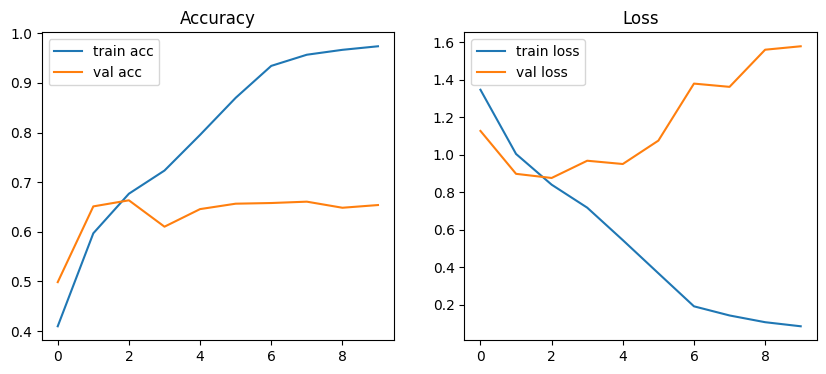

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.legend()
plt.show()


In [ ]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.2f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 422ms/step - accuracy: 0.6549 - loss: 1.6886
Validation Accuracy: 0.65


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step


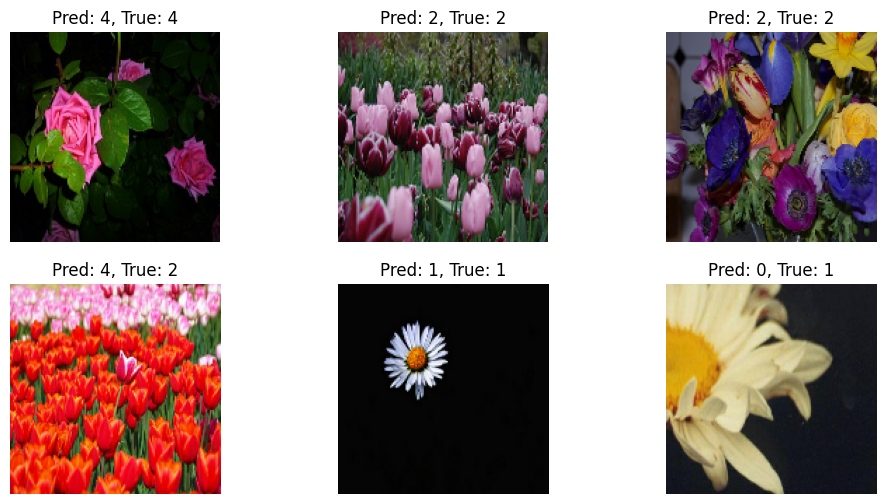

In [ ]:
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)

plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    plt.title(f"Pred: {pred_labels[i]}, True: {labels[i].numpy()}")
    plt.axis('off')
plt.show()
